<a href="https://colab.research.google.com/github/kevinzhuang01/assure-us_2023/blob/main/2023_Data_Science_Research_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Dataset

In [ ]:
# Import modules
import kagglehub
import pandas as pd
import scipy
import numpy as np
import matplotlib
import seaborn as sns
import torch
from torch import nn

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error

In [ ]:
# Download latest version of dataset (https://www.kaggle.com/datasets/lainguyn123/student-performance-factors)
path = kagglehub.dataset_download("lainguyn123/student-performance-factors")

student_performance = pd.read_csv(path + '/StudentPerformanceFactors.csv')

student_performance

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,25,69,High,Medium,No,7,76,Medium,Yes,1,High,Medium,Public,Positive,2,No,High School,Near,Female,68
6603,23,76,High,Medium,No,8,81,Medium,Yes,3,Low,High,Public,Positive,2,No,High School,Near,Female,69
6604,20,90,Medium,Low,Yes,6,65,Low,Yes,3,Low,Medium,Public,Negative,2,No,Postgraduate,Near,Female,68
6605,10,86,High,High,Yes,6,91,High,Yes,2,Low,Medium,Private,Positive,3,No,High School,Far,Female,68


# Data Wrangling

In [ ]:
# Drop missing values
student_performance = student_performance.dropna()

# Encode nominal variables
nom_var = ['Extracurricular_Activities', 'Internet_Access', 'School_Type', 'Learning_Disabilities', 'Gender']
student_performance = pd.get_dummies(student_performance, columns = nom_var, drop_first = True)

# Encode ordinal variables
ord_var_lmh = ['Parental_Involvement', 'Access_to_Resources', 'Motivation_Level', 'Family_Income', 'Teacher_Quality']
categories_lmh = [['Low','Medium','High'] for _ in range(5)]
ord_enc_lmh = OrdinalEncoder(categories = categories_lmh)
student_performance[ord_var_lmh] = ord_enc_lmh.fit_transform(student_performance[ord_var_lmh])

student_performance[['Peer_Influence']] = OrdinalEncoder(categories = [['Negative', 'Neutral', 'Positive']]).fit_transform(student_performance[['Peer_Influence']])
student_performance[['Parental_Education_Level']] = OrdinalEncoder(categories = [['High School', 'College', 'Postgraduate']]).fit_transform(student_performance[['Parental_Education_Level']])
student_performance[['Distance_from_Home']] = OrdinalEncoder(categories = [['Near', 'Moderate', 'Far']]).fit_transform(student_performance[['Distance_from_Home']])

In [ ]:
student_performance

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Sleep_Hours,Previous_Scores,Motivation_Level,Tutoring_Sessions,Family_Income,Teacher_Quality,Peer_Influence,Physical_Activity,Parental_Education_Level,Distance_from_Home,Exam_Score,Extracurricular_Activities_Yes,Internet_Access_Yes,School_Type_Public,Learning_Disabilities_Yes,Gender_Male
0,23,84,0.0,2.0,7,73,0.0,0,0.0,1.0,2.0,3,0.0,0.0,67,False,True,True,False,True
1,19,64,0.0,1.0,8,59,0.0,2,1.0,1.0,0.0,4,1.0,1.0,61,False,True,True,False,False
2,24,98,1.0,1.0,7,91,1.0,2,1.0,1.0,1.0,4,2.0,0.0,74,True,True,True,False,True
3,29,89,0.0,1.0,8,98,1.0,1,1.0,1.0,0.0,4,0.0,1.0,71,True,True,True,False,True
4,19,92,1.0,1.0,6,65,1.0,3,1.0,2.0,1.0,4,1.0,0.0,70,True,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,25,69,2.0,1.0,7,76,1.0,1,2.0,1.0,2.0,2,0.0,0.0,68,False,True,True,False,False
6603,23,76,2.0,1.0,8,81,1.0,3,0.0,2.0,2.0,2,0.0,0.0,69,False,True,True,False,False
6604,20,90,1.0,0.0,6,65,0.0,3,0.0,1.0,0.0,2,2.0,0.0,68,True,True,True,False,False
6605,10,86,2.0,2.0,6,91,2.0,2,0.0,1.0,2.0,3,0.0,2.0,68,True,True,False,False,False


In [ ]:
# X = all columns except Exam_Score
X = student_performance.drop('Exam_Score', axis = 'columns')
# y = Exam_Score
y = student_performance['Exam_Score']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = 42)

# Linear Regression

In [ ]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
print(f"Intercept: {lin_reg.intercept_}")

print("Coefficients:")
coef = list(zip(lin_reg.feature_names_in_, lin_reg.coef_))
for feature in coef:
  print(f"  {feature}")

Intercept: 34.94819502247556
Coefficients:
  ('Hours_Studied', 0.2963350325294447)
  ('Attendance', 0.19813447020389313)
  ('Parental_Involvement', 1.0185661392043044)
  ('Access_to_Resources', 1.0344260243815588)
  ('Sleep_Hours', -0.014782104354789695)
  ('Previous_Scores', 0.04877819817684972)
  ('Motivation_Level', 0.588473478561566)
  ('Tutoring_Sessions', 0.47719772083051937)
  ('Family_Income', 0.5538788997563737)
  ('Teacher_Quality', 0.5328775519522738)
  ('Peer_Influence', 0.4944659641881559)
  ('Physical_Activity', 0.19896025432738)
  ('Parental_Education_Level', 0.4955454252596396)
  ('Distance_from_Home', -0.47859719208265356)
  ('Extracurricular_Activities_Yes', 0.5685138928455606)
  ('Internet_Access_Yes', 0.874474135300408)
  ('School_Type_Public', 0.06775854419907489)
  ('Learning_Disabilities_Yes', -0.8665532192958476)
  ('Gender_Male', 0.014464051837298972)


In [ ]:
print("Most Significant Coefficients:")
for feature in sorted(coef, key = lambda x: abs(x[1]), reverse = True):
  print(f"  {feature}")

Most Significant Coefficients:
  ('Access_to_Resources', 1.0344260243815588)
  ('Parental_Involvement', 1.0185661392043044)
  ('Internet_Access_Yes', 0.874474135300408)
  ('Learning_Disabilities_Yes', -0.8665532192958476)
  ('Motivation_Level', 0.588473478561566)
  ('Extracurricular_Activities_Yes', 0.5685138928455606)
  ('Family_Income', 0.5538788997563737)
  ('Teacher_Quality', 0.5328775519522738)
  ('Parental_Education_Level', 0.4955454252596396)
  ('Peer_Influence', 0.4944659641881559)
  ('Distance_from_Home', -0.47859719208265356)
  ('Tutoring_Sessions', 0.47719772083051937)
  ('Hours_Studied', 0.2963350325294447)
  ('Physical_Activity', 0.19896025432738)
  ('Attendance', 0.19813447020389313)
  ('School_Type_Public', 0.06775854419907489)
  ('Previous_Scores', 0.04877819817684972)
  ('Sleep_Hours', -0.014782104354789695)
  ('Gender_Male', 0.014464051837298972)


In [ ]:
print("Linear Regression Metrics (Training Set)")

y_train_pred = lin_reg.predict(X_train)

# Print Coefficient of Determination (R^2)
r2_train = r2_score(y_train, y_train_pred)
print(f"R^2 (Training Set): {r2_train * 100:.2f}%")

# Print error metrics for training set
rmse_train = root_mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
print(f"Root Mean Squared Error (Training Set): {rmse_train:.2f}")
print(f"Mean Absolute Error (Training Set): {mae_train:.2f}")

Linear Regression Metrics (Training Set)
R^2 (Training Set): 72.74%
Root Mean Squared Error (Training Set): 2.02
Mean Absolute Error (Training Set): 0.48


In [ ]:
print("Linear Regression Metrics (Testing Set)")

y_test_pred = lin_reg.predict(X_test)

# Print Coefficient of Determination (R^2)
r2_test = r2_score(y_test, y_test_pred)
print(f"R^2 (Testing Set): {r2_test * 100:.2f}%")

rmse_test = root_mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Print error metrics for testing set
print(f"Root Mean Squared Error (Testing Set): {rmse_test:.2f}")
print(f"Mean Absolute Error (Testing Set): {mae_test:.2f}")

Linear Regression Metrics (Testing Set)
R^2 (Testing Set): 70.40%
Root Mean Squared Error (Testing Set): 2.20
Mean Absolute Error (Testing Set): 0.51


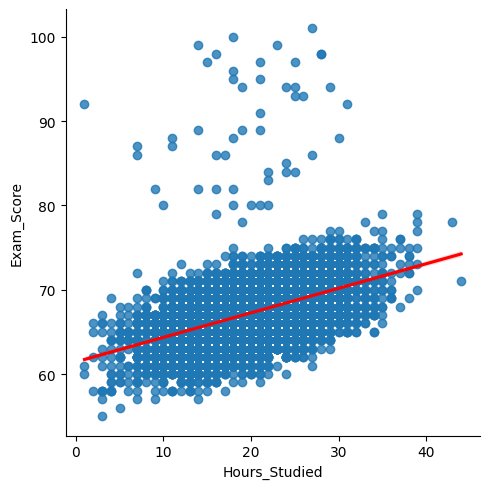

In [ ]:
# Plot
sns.lmplot(data = student_performance, x = "Hours_Studied", y = "Exam_Score", line_kws={'color': 'red'})

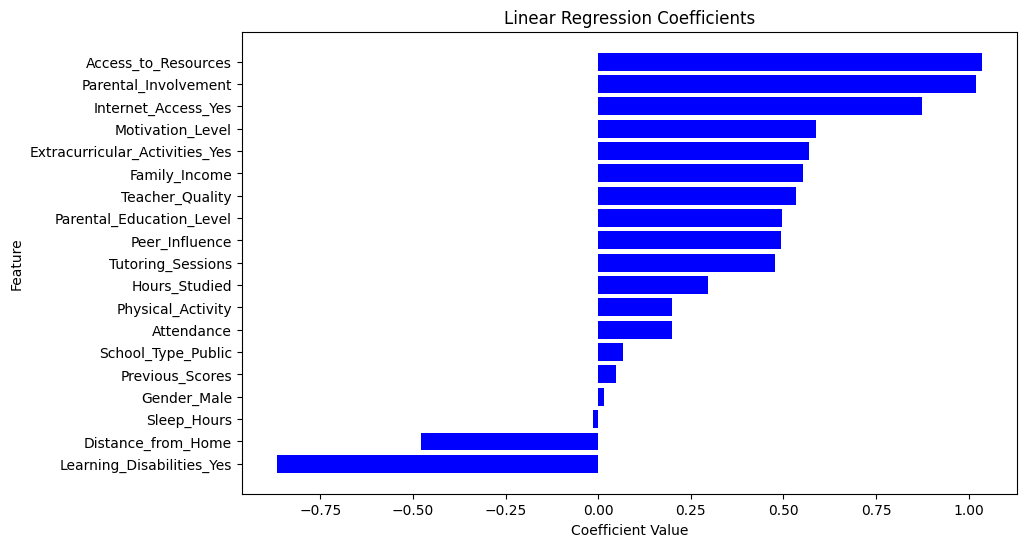

In [ ]:
coefficients = lin_reg.coef_

# Sort coefficients for better visualization
sorted_idx = np.argsort(coefficients)
sorted_coefficients = coefficients[sorted_idx]
sorted_feature_names = np.array(lin_reg.feature_names_in_)[sorted_idx]

# Create a bar plot
matplotlib.pyplot.figure(figsize=(10, 6))
matplotlib.pyplot.barh(sorted_feature_names, sorted_coefficients, color="blue")
matplotlib.pyplot.xlabel("Coefficient Value")
matplotlib.pyplot.ylabel("Feature")
matplotlib.pyplot.title("Linear Regression Coefficients")
matplotlib.pyplot.show()

# Ridge Regression (L2 Regularization)

In [ ]:
# Ridge Regression (L2 Regularization)
ridge_reg = Ridge(random_state = 42)

In [ ]:
# Tune
# param_dist = {
#     'alpha': scipy.stats.uniform(0, 500)
# }

# ridge_tune = RandomizedSearchCV(ridge_reg, param_distributions = param_dist, n_iter = 1000, cv = 5, random_state = 42)

param_grid = {
    'alpha': np.logspace(-5, 3, num = 100)
}

ridge_tune = GridSearchCV(ridge_reg, param_grid = param_grid)

ridge_reg = ridge_tune.fit(X_train, y_train).best_estimator_

In [ ]:
print(f"Intercept: {ridge_reg.intercept_}")

print("Coefficients:")
coef = list(zip(ridge_reg.feature_names_in_, ridge_reg.coef_))
for feature in coef:
  print(f"  {feature}")

Intercept: 34.953526704130475
Coefficients:
  ('Hours_Studied', 0.2963324933683712)
  ('Attendance', 0.1981337876898123)
  ('Parental_Involvement', 1.018071700817716)
  ('Access_to_Resources', 1.0339188185601014)
  ('Sleep_Hours', -0.014785603471159392)
  ('Previous_Scores', 0.04877741665986289)
  ('Motivation_Level', 0.5882093650402542)
  ('Tutoring_Sessions', 0.477123621950964)
  ('Family_Income', 0.5536757681388806)
  ('Teacher_Quality', 0.5325441372486986)
  ('Peer_Influence', 0.49431043207801684)
  ('Physical_Activity', 0.19887873713819543)
  ('Parental_Education_Level', 0.49536076207399365)
  ('Distance_from_Home', -0.4783773693081785)
  ('Extracurricular_Activities_Yes', 0.5680096331244334)
  ('Internet_Access_Yes', 0.871706745648368)
  ('School_Type_Public', 0.06767552973614055)
  ('Learning_Disabilities_Yes', -0.8645338039921723)
  ('Gender_Male', 0.014489064421225571)


In [ ]:
print("Most Significant Coefficients:")
for feature in sorted(coef, key = lambda x: abs(x[1]), reverse = True):
  print(f"  {feature}")

Most Significant Coefficients:
  ('Access_to_Resources', 1.0339188185601014)
  ('Parental_Involvement', 1.018071700817716)
  ('Internet_Access_Yes', 0.871706745648368)
  ('Learning_Disabilities_Yes', -0.8645338039921723)
  ('Motivation_Level', 0.5882093650402542)
  ('Extracurricular_Activities_Yes', 0.5680096331244334)
  ('Family_Income', 0.5536757681388806)
  ('Teacher_Quality', 0.5325441372486986)
  ('Parental_Education_Level', 0.49536076207399365)
  ('Peer_Influence', 0.49431043207801684)
  ('Distance_from_Home', -0.4783773693081785)
  ('Tutoring_Sessions', 0.477123621950964)
  ('Hours_Studied', 0.2963324933683712)
  ('Physical_Activity', 0.19887873713819543)
  ('Attendance', 0.1981337876898123)
  ('School_Type_Public', 0.06767552973614055)
  ('Previous_Scores', 0.04877741665986289)
  ('Sleep_Hours', -0.014785603471159392)
  ('Gender_Male', 0.014489064421225571)


In [ ]:
print("Ridge Regression Metrics (Training Set)")

y_train_pred = ridge_reg.predict(X_train)

# Print Coefficient of Determination (R^2)
r2_train = r2_score(y_train, y_train_pred)
print(f"R^2 (Training Set): {r2_train * 100:.2f}%")

# Print error metrics for training set
rmse_train = root_mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
print(f"Root Mean Squared Error (Training Set): {rmse_train:.2f}")
print(f"Mean Absolute Error (Training Set): {mae_train:.2f}")

Ridge Regression Metrics (Training Set)
R^2 (Training Set): 72.74%
Root Mean Squared Error (Training Set): 2.02
Mean Absolute Error (Training Set): 0.48


In [ ]:
print("Ridge Regression Metrics (Testing Set)")

y_test_pred = ridge_reg.predict(X_test)

# Print Coefficient of Determination (R^2)
r2_test = r2_score(y_test, y_test_pred)
print(f"R^2 (Testing Set): {r2_test * 100:.2f}%")

rmse_test = root_mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Print error metrics for testing set
print(f"Root Mean Squared Error (Testing Set): {rmse_test:.2f}")
print(f"Mean Absolute Error (Testing Set): {mae_test:.2f}")

Ridge Regression Metrics (Testing Set)
R^2 (Testing Set): 70.40%
Root Mean Squared Error (Testing Set): 2.20
Mean Absolute Error (Testing Set): 0.51


# LASSO Regression (L1 Regularization)

In [ ]:
# LASSO Regression (L1 Regularization)
lasso_reg = Lasso(random_state = 42)

In [ ]:
# Tune
# param_dist = {
#     'alpha': scipy.stats.uniform(0, 500)
# }

# lasso_tune = RandomizedSearchCV(lasso_reg, param_distributions = param_dist, n_iter = 1000, cv = 5, random_state = 42)

param_grid = {
    'alpha': np.logspace(-5, 3, num = 100)
}

lasso_tune = GridSearchCV(lasso_reg, param_grid = param_grid)

lasso_reg = lasso_tune.fit(X_train, y_train).best_estimator_

In [ ]:
print(f"Intercept: {lasso_reg.intercept_}")

print("Coefficients:")
coef = list(zip(lasso_reg.feature_names_in_, lasso_reg.coef_))
for feature in coef:
  print(f"  {feature}")

Intercept: 35.00724068296033
Coefficients:
  ('Hours_Studied', 0.2962694443923454)
  ('Attendance', 0.1981178115837045)
  ('Parental_Involvement', 1.014918294181423)
  ('Access_to_Resources', 1.0306955962812476)
  ('Sleep_Hours', -0.014194800628560916)
  ('Previous_Scores', 0.048764880753156464)
  ('Motivation_Level', 0.5853305332971975)
  ('Tutoring_Sessions', 0.4762103920646394)
  ('Family_Income', 0.5512407057231479)
  ('Teacher_Quality', 0.5284104403616622)
  ('Peer_Influence', 0.49210482066392286)
  ('Physical_Activity', 0.1971022851017584)
  ('Parental_Education_Level', 0.49275120142699386)
  ('Distance_from_Home', -0.47511819877889977)
  ('Extracurricular_Activities_Yes', 0.5622756032412736)
  ('Internet_Access_Yes', 0.8522522930126766)
  ('School_Type_Public', 0.060332204788286374)
  ('Learning_Disabilities_Yes', -0.850323268902051)
  ('Gender_Male', 0.008587922393933193)


In [ ]:
print("Most Significant Coefficients:")
for feature in sorted(coef, key = lambda x: abs(x[1]), reverse = True):
  print(f"  {feature}")

Most Significant Coefficients:
  ('Access_to_Resources', 1.0306955962812476)
  ('Parental_Involvement', 1.014918294181423)
  ('Internet_Access_Yes', 0.8522522930126766)
  ('Learning_Disabilities_Yes', -0.850323268902051)
  ('Motivation_Level', 0.5853305332971975)
  ('Extracurricular_Activities_Yes', 0.5622756032412736)
  ('Family_Income', 0.5512407057231479)
  ('Teacher_Quality', 0.5284104403616622)
  ('Parental_Education_Level', 0.49275120142699386)
  ('Peer_Influence', 0.49210482066392286)
  ('Tutoring_Sessions', 0.4762103920646394)
  ('Distance_from_Home', -0.47511819877889977)
  ('Hours_Studied', 0.2962694443923454)
  ('Attendance', 0.1981178115837045)
  ('Physical_Activity', 0.1971022851017584)
  ('School_Type_Public', 0.060332204788286374)
  ('Previous_Scores', 0.048764880753156464)
  ('Sleep_Hours', -0.014194800628560916)
  ('Gender_Male', 0.008587922393933193)


In [ ]:
print("LASSO Regression Metrics (Training Set)")

y_train_pred = lasso_reg.predict(X_train)

# Print Coefficient of Determination (R^2)
r2_train = r2_score(y_train, y_train_pred)
print(f"R^2 (Training Set): {r2_train * 100:.2f}%")

# Print error metrics for training set
rmse_train = root_mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
print(f"Root Mean Squared Error (Training Set): {rmse_train:.2f}")
print(f"Mean Absolute Error (Training Set): {mae_train:.2f}")

LASSO Regression Metrics (Training Set)
R^2 (Training Set): 72.74%
Root Mean Squared Error (Training Set): 2.02
Mean Absolute Error (Training Set): 0.48


In [ ]:
print("LASSO Regression Metrics (Testing Set)")

y_test_pred = lasso_reg.predict(X_test)

# Print Coefficient of Determination (R^2)
r2_test = r2_score(y_test, y_test_pred)
print(f"R^2 (Testing Set): {r2_test * 100:.2f}%")

rmse_test = root_mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Print error metrics for testing set
print(f"Root Mean Squared Error (Testing Set): {rmse_test:.2f}")
print(f"Mean Absolute Error (Testing Set): {mae_test:.2f}")

LASSO Regression Metrics (Testing Set)
R^2 (Testing Set): 70.41%
Root Mean Squared Error (Testing Set): 2.20
Mean Absolute Error (Testing Set): 0.51


# Decision Tree

In [ ]:
# Decision Tree
tree_reg = DecisionTreeRegressor(random_state = 42)
# tree_reg.fit(X_train, y_train)

In [ ]:
# Tune

# param_dist = {
#     'max_depth': scipy.stats.randint(1, 20),
#     'min_samples_split': scipy.stats.randint(2, 40),
#     'ccp_alpha': scipy.stats.uniform(0, 2)
# }

# tree_tune = RandomizedSearchCV(tree_reg, param_distributions = param_dist, n_iter = 500, random_state = 42)

param_grid = {
    'max_depth': range(1, 21, 3),
    'min_samples_split': range(2, 40, 5),
    'ccp_alpha': np.logspace(-5, 1, num = 10)
}

tree_tune = GridSearchCV(tree_reg, param_grid = param_grid)

tree_reg = tree_tune.fit(X_train, y_train).best_estimator_

In [ ]:
print(f"Depth: {tree_reg.get_depth()}")
print(f"Number of Leaves: {tree_reg.get_n_leaves()}")

print("Feature Importances:")
feat_imp = list(zip(tree_reg.feature_names_in_, tree_reg.feature_importances_))
for feature in feat_imp:
  print(f"  {feature}")

Depth: 13
Number of Leaves: 252
Feature Importances:
  ('Hours_Studied', 0.31043051839314156)
  ('Attendance', 0.49241229428828337)
  ('Parental_Involvement', 0.02581984410674712)
  ('Access_to_Resources', 0.037696498411173764)
  ('Sleep_Hours', 0.010258859239635102)
  ('Previous_Scores', 0.05139590252407358)
  ('Motivation_Level', 0.00398822439978347)
  ('Tutoring_Sessions', 0.01988849547934973)
  ('Family_Income', 0.009408593742376691)
  ('Teacher_Quality', 0.0021919324531793506)
  ('Peer_Influence', 0.01016460637168182)
  ('Physical_Activity', 0.01092490676771479)
  ('Parental_Education_Level', 0.007745874311681745)
  ('Distance_from_Home', 0.003423691018654607)
  ('Extracurricular_Activities_Yes', 0.0004853783660597893)
  ('Internet_Access_Yes', 0.001614729263345488)
  ('School_Type_Public', 0.0)
  ('Learning_Disabilities_Yes', 0.0021496508631180344)
  ('Gender_Male', 0.0)


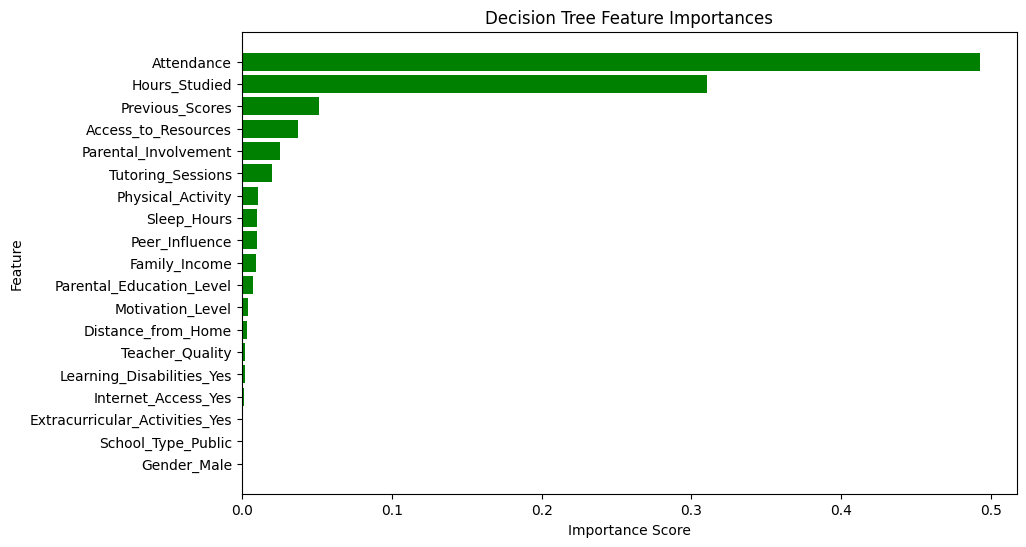

In [ ]:
importances = tree_reg.feature_importances_

# Sort importances for better visualization
sorted_idx = np.argsort(importances)
sorted_importances = importances[sorted_idx]
sorted_feature_names = np.array(tree_reg.feature_names_in_)[sorted_idx]

# Create a bar plot
matplotlib.pyplot.figure(figsize=(10, 6))
matplotlib.pyplot.barh(sorted_feature_names, sorted_importances, color="green")
matplotlib.pyplot.xlabel("Importance Score")
matplotlib.pyplot.ylabel("Feature")
matplotlib.pyplot.title("Decision Tree Feature Importances")
matplotlib.pyplot.show()


[Text(0.5295194738051471, 0.9642857142857143, 'x[1] <= 82.5\nsquared_error = 14.979\nsamples = 4783\nvalue = 67.243'),
 Text(0.27037856158088236, 0.8928571428571429, 'x[0] <= 20.5\nsquared_error = 11.394\nsamples = 2721\nvalue = 65.574'),
 Text(0.3999490176930147, 0.9285714285714286, 'True  '),
 Text(0.12005974264705882, 0.8214285714285714, 'x[1] <= 70.5\nsquared_error = 9.267\nsamples = 1438\nvalue = 64.289'),
 Text(0.06387867647058823, 0.75, 'x[0] <= 15.5\nsquared_error = 8.854\nsamples = 663\nvalue = 63.012'),
 Text(0.043198529411764705, 0.6785714285714286, 'x[8] <= 1.5\nsquared_error = 9.803\nsamples = 282\nvalue = 61.929'),
 Text(0.03125, 0.6071428571428571, 'x[1] <= 66.5\nsquared_error = 6.445\nsamples = 222\nvalue = 61.554'),
 Text(0.01838235294117647, 0.5357142857142857, 'x[0] <= 12.5\nsquared_error = 2.805\nsamples = 139\nvalue = 60.971'),
 Text(0.011029411764705883, 0.4642857142857143, 'x[5] <= 80.5\nsquared_error = 2.688\nsamples = 64\nvalue = 60.25'),
 Text(0.00735294117647

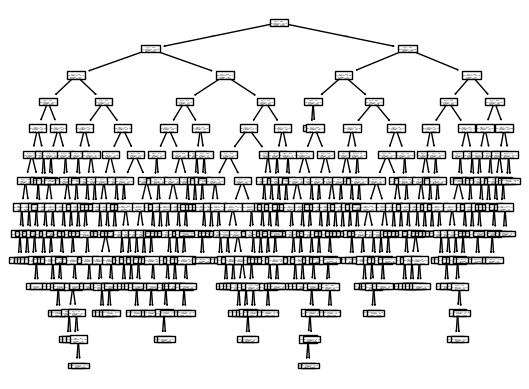

In [ ]:
plot_tree(tree_reg)

In [ ]:
print("Decision Tree Regression Metrics (Training Set)")

y_train_pred = tree_reg.predict(X_train)

# Print Coefficient of Determination (R^2)
r2_train = r2_score(y_train, y_train_pred)
print(f"R^2 (Training Set): {r2_train * 100:.2f}%")

# Print error metrics for training set
rmse_train = root_mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
print(f"Root Mean Squared Error (Training Set): {rmse_train:.2f}")
print(f"Mean Absolute Error (Training Set): {mae_train:.2f}")

Decision Tree Regression Metrics (Training Set)
R^2 (Training Set): 70.31%
Root Mean Squared Error (Training Set): 2.11
Mean Absolute Error (Training Set): 1.21


In [ ]:
print("Decision Tree Regression Metrics (Testing Set)")

y_test_pred = tree_reg.predict(X_test)

# Print Coefficient of Determination (R^2)
r2_test = r2_score(y_test, y_test_pred)
print(f"R^2 (Testing Set): {r2_test * 100:.2f}%")

rmse_test = root_mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Print error metrics for testing set
print(f"Root Mean Squared Error (Testing Set): {rmse_test:.2f}")
print(f"Mean Absolute Error (Testing Set): {mae_test:.2f}")

Decision Tree Regression Metrics (Testing Set)
R^2 (Testing Set): 50.64%
Root Mean Squared Error (Testing Set): 2.84
Mean Absolute Error (Testing Set): 1.59


# Neural Network

In [ ]:
# If using pytorch or tf we should try using CUDA, which the VM hosting this instance should be able to run.

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
#validation set created by splitting off 50% of test set
nn_X_val, nn_X_test, nn_y_val, nn_y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
nn_X_train = X_train.astype(np.float32)
nn_y_train = y_train.astype(np.float32)

nn_X_val, nn_X_test, nn_y_val, nn_y_test = train_test_split(X_test.astype(np.float32), y_test.astype(np.float32), test_size=0.5, random_state=42)

train_data = TensorDataset(torch.tensor(nn_X_train.values, dtype=torch.float32), torch.tensor(nn_y_train.values, dtype=torch.float32))
val_data = TensorDataset(torch.tensor(nn_X_val.values, dtype=torch.float32), torch.tensor(nn_y_val.values, dtype=torch.float32))
test_data = TensorDataset(torch.tensor(nn_X_test.values, dtype=torch.float32), torch.tensor(nn_y_test.values, dtype=torch.float32))

bsize = 64

train_loader = DataLoader(train_data, batch_size=bsize, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=bsize, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=bsize, shuffle=False, pin_memory=True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class GradePredictionModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 16)
        self.fc5 = nn.Linear(16, 16)
        self.fc6 = nn.Linear(16, 16)
        self.fc7 = nn.Linear(16, 16)
        self.fc8 = nn.Linear(16, 16)
        self.fc9 = nn.Linear(16, 16)
        self.fc10 = nn.Linear(16, 16)
        self.fc11 = nn.Linear(16, 16)
        self.fc12 = nn.Linear(16, 16)
        self.fc13 = nn.Linear(16, 16)
        self.fc14 = nn.Linear(16, 16)
        self.fc15 = nn.Linear(16, 16)
        self.fc16 = nn.Linear(16, 16)
        self.fc17 = nn.Linear(16, 16)
        self.fc18 = nn.Linear(16, 16)
        self.fc19 = nn.Linear(16, 16)
        self.fc20 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = F.relu(self.fc9(x))
        x = F.relu(self.fc10(x))
        x = F.relu(self.fc11(x))
        x = F.relu(self.fc12(x))
        x = F.relu(self.fc13(x))
        x = F.relu(self.fc14(x))
        x = F.relu(self.fc15(x))
        x = F.relu(self.fc16(x))
        x = F.relu(self.fc17(x))
        x = F.relu(self.fc18(x))
        x = F.relu(self.fc19(x))
        x = self.fc20(x)  # Output layer (no activation for regression)
        return x

input_size = X_train.shape[1]  # Number of features
model = GradePredictionModel(input_size).to(device)

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
epochs = 200
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.unsqueeze(1))
        loss.backward()
        optimizer.step()

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actual_values = []

    with torch.no_grad():  # Disable gradient calculation
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            predictions.extend(output.cpu().numpy().flatten())  # Move to CPU, flatten
            actual_values.extend(target.cpu().numpy().flatten())

    mse = mean_squared_error(actual_values, predictions)
    rmse = root_mean_squared_error(actual_values, predictions)
    r2 = r2_score(actual_values, predictions)

    return mse, rmse, r2
print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")
print("Training")
mse, rmse, r2 = evaluate_model(model, train_loader, device)
print(f'MSE: {mse:.4f}\nRMSE: {rmse:.4f}\nR-squared: {r2:.4f}')
print("Validation:")
mse, rmse, r2 = evaluate_model(model, val_loader, device)  # Evaluate on validation set
print(f'MSE: {mse:.4f}\nRMSE: {rmse:.4f}\nR-squared: {r2:.4f}')
print("Testing:")
mse, rmse, r2 = evaluate_model(model, test_loader, device)  # Evaluate on testing set
print(f'MSE: {mse:.4f}\nRMSE: {rmse:.4f}\nR-squared: {r2:.4f}')

Epoch 200/200, Loss: 0.13345013558864594
Training
MSE: 5.1324
RMSE: 2.2655
R-squared: 0.6573
Validation:
MSE: 3.1995
RMSE: 1.7887
R-squared: 0.7668
Testing:
MSE: 8.6706
RMSE: 2.9446
R-squared: 0.5403
